# Logistic Regression IC Benchmark

In [5]:
import torch
import numpy as np

torch.manual_seed(42)
np.random.seed(42)

In [6]:
from typing import Dict, List, Optional, Tuple
import numpy as np
import torch
from torch import Tensor
import torch.distributions as dist
import torch.optim as optim
import beanmachine.ppl as bm
from beanmachine.ppl.model.statistical_model import StatisticalModel
from pplbench.PPLBench import PPLBenchPPL


import beanmachine.ppl.experimental.inference_compilation.ic_infer as ic_infer

StatisticalModel.reset()
torch.autograd.set_detect_anomaly(False) 


class LogisticRegressionModel(object):
    def __init__(
        self,
        N: int,
        K: int,
        scale_alpha: float,
        scale_beta: List[float],
        loc_beta: float,
        num_samples: int,
        num_adaptive_samples: int,
        inference_type: str,
        X: Tensor,
        Y: Tensor,
        ic_args: Optional[dict],
    ):
        self.N = N
        self.K = K
        self.scale_alpha = scale_alpha
        self.scale_beta = scale_beta
        self.loc_beta = loc_beta
        self.num_samples = num_samples
        self.num_adaptive_samples = num_adaptive_samples
        self.inference_type = inference_type
        self.X = torch.cat((torch.ones((1, N)), X))
        self.Y = Y
        if self.inference_type == "ic":
            self.ic = ic_infer.ICInference().compile(
                [self.y()],
                num_worlds=ic_args["num_worlds"],
                optimizer_func=lambda p: optim.Adam(p, lr=ic_args["lr"], weight_decay=ic_args["wd"]),
                gmm_num_components=ic_args["num_gmm_components"],
            )

    @bm.random_variable
    def beta(self):
        return dist.Normal(
            tensor([0.0] + [self.loc_beta] * self.K),
            tensor([self.scale_alpha] + self.scale_beta),
        )

    @bm.random_variable
    def y(self):
        # Compute X * Beta
        beta_ = self.beta().reshape((1, self.beta().shape[0]))
        mu = beta_.mm(self.X)
        return dist.Bernoulli(logits=mu)

    def infer(self):
        num_adaptive_samples = self.num_adaptive_samples
        dict_y = {self.y(): self.Y}
        if self.inference_type == "mcmc":
            nmc = bm.SingleSiteNewtonianMonteCarlo()
            start_time = time.time()
            samples = nmc.infer([self.beta()], dict_y, self.num_samples, 1,
                               num_adaptive_samples=num_adaptive_samples).get_chain()
        elif self.inference_type == "mcmc-ancestral":
            mh = bm.SingleSiteAncestralMetropolisHastings()
            start_time = time.time()
            samples = mh.infer([self.beta()], dict_y, self.num_samples, 1,
                               num_adaptive_samples=num_adaptive_samples).get_chain()
        elif self.inference_type == "mcmc-rw":
            mh = bm.SingleSiteRandomWalk()
            start_time = time.time()
            samples = mh.infer([self.beta()], dict_y, self.num_samples, 1,
                               num_adaptive_samples=num_adaptive_samples).get_chain()
        elif self.inference_type == "ic":
            start_time = time.time()
            samples = self.ic.infer(
                queries=[self.beta()],
                observations=dict_y,
                num_samples=self.num_samples,
                num_chains=1,
                num_adaptive_samples=num_adaptive_samples).get_chain()
        elif self.inference_type == "vi":
            print("ImplementationError; exiting...")
            exit(1)
        elapsed_time_sample_beanmachine = time.time() - start_time
        return (samples, elapsed_time_sample_beanmachine)


class LogisticRegression(PPLBenchPPL):
    def obtain_posterior(
        self, 
        data_train: Tuple[np.ndarray, np.ndarray], 
        args_dict: Dict, 
        model=None,
    ) -> Tuple[List, Dict]:
        """
        Beanmachine impmementation of logisitc regression model.

        :param data_train: tuple of np.ndarray (x_train, y_train)
        :param args_dict: a dict of model arguments
        :returns: samples_beanmachine(list of dict): posterior samples of all parameters
        :returns: timing_info(dict): compile_time, inference_time
        """
        # shape of x_train: (num_features, num_samples)
        x_train, y_train = data_train
        y_train = np.array(y_train, dtype=np.float32)
        x_train = np.array(x_train, dtype=np.float32)
        x_train = tensor(x_train)
        y_train = tensor([tensor(y) for y in y_train])
        N = int(x_train.shape[1])
        K = int(x_train.shape[0])

        alpha_scale = float((args_dict["model_args"])[0])
        beta_scale = [float((args_dict["model_args"])[1])] * K
        beta_loc = float((args_dict["model_args"])[2])
        num_adaptive_samples = args_dict["num_adaptive_samples"]
        num_samples = args_dict["num_samples_beanmachine_vectorized"]
        inference_type = args_dict["inference_type"]

        start_time = time.time()
        self.logistic_regression_model = LogisticRegressionModel(
            N,
            K,
            alpha_scale,
            beta_scale,
            beta_loc,
            num_samples,
            num_adaptive_samples,
            inference_type,
            x_train,
            y_train,
            ic_args=args_dict.get("ic", None),
        )
        logistic_regression_model = self.logistic_regression_model
        elapsed_time_compile_beanmachine = time.time() - start_time
        samples, elapsed_time_sample_beanmachine = logistic_regression_model.infer()

        # repackage samples into format required by PPLBench
        # List of dict, where each dict has key = param (string), value = value of param
        param_keys = ["beta", "alpha"]
        samples_formatted = []
        for i in range(num_samples):
            sample_dict = {}
            for j, parameter in enumerate(samples.get_rv_names()):
                sample_dict[param_keys[j]] = (
                    samples.get_variable(parameter)[i][1:].detach().numpy()
                )
                sample_dict[param_keys[1]] = (
                    samples.get_variable(parameter)[i][0].detach().numpy()
                )
            samples_formatted.append(sample_dict)

        timing_info = {
            "compile_time": elapsed_time_compile_beanmachine,
            "inference_time": elapsed_time_sample_beanmachine,
        }
        return (samples_formatted, timing_info)


In [7]:
timing_infos = {}
posterior_samples = {}
posterior_predictive = {}

## BM

In [8]:
import time
import numpy as np
import pandas as pd

import torch
import torch.distributions as dist
from torch import tensor

import pplbench.models.logistic_regression_model as model

_model = model

args_dict = model.get_defaults()
args_dict["model_args"] = [1, 1, 0, 10]
args_dict["num_adaptive_samples"] = int(1e3)
args_dict["trials"] = 10
args_dict["plot_data_size"] = 100
args_dict["num_samples"] = 100
args_dict["ic"] = {
    "num_worlds": int(1e3),
    "lr": 1e-2,
    "wd": 1e-3,
    "num_gmm_components": 1,
}
#args_dict["inference_type"] = "mcmc"
args_dict["num_samples_beanmachine_vectorized"] = 100

model_instance = model.generate_model(args_dict)
generated_data = model.generate_data(args_dict=args_dict, model=model_instance)
ppl_instance = LogisticRegression()

for ppl,inference_type in [
    #('BM_IC', 'ic'),
    ('BM_ancestral', 'mcmc-ancestral'),
    #('BM_rw', 'mcmc-rw'),
    #('BM_nmc', 'mcmc'),
]:
    args_dict["inference_type"] = inference_type
    timing_infos[ppl] = [None] * int(args_dict["trials"])
    posterior_samples[ppl] = [None] * int(args_dict["trials"])
    posterior_predictive[ppl] = [None] * int(args_dict["trials"])
    ic = None

    # start trial loop
    for i in range(int(args_dict["trials"])):
        print("Starting trial", i + 1, "of", args_dict["trials"])

        # obtain posterior samples and timing info
        data_train=generated_data["data_train"]
        (
            posterior_samples[ppl][i],
            timing_infos[ppl][i],
        ) = ppl_instance.obtain_posterior(data_train, args_dict)

        # compute posterior predictive
        posterior_predictive[ppl][i] = model.evaluate_posterior_predictive(
            samples=posterior_samples[ppl][i].copy(),
            data_test=generated_data["data_test"],
            model=model_instance,
        )
        print(
            f"Trial {i + 1} "
            f'complete in {timing_infos[ppl][i]["inference_time"]} '
            "seconds.\n Statistics of  posterior predictive\n mean:"
            f"{np.array(posterior_predictive[ppl][i]).mean()}"
            f"\n var: {np.array(posterior_predictive[ppl][i]).var()}"
        )

Generating data
Starting trial 1 of 10



Trial 1 complete in 21.141939878463745 seconds.
 Statistics of  posterior predictive
 mean:-0.2732903578396039
 var: 1.4391584775944621
Starting trial 2 of 10



Trial 2 complete in 20.924611806869507 seconds.
 Statistics of  posterior predictive
 mean:-0.4808312167310067
 var: 7.4747540172614455
Starting trial 3 of 10



Trial 3 complete in 21.18734073638916 seconds.
 Statistics of  posterior predictive
 mean:-0.6734424417388789
 var: 17.925556394951563
Starting trial 4 of 10



Trial 4 complete in 21.06873846054077 seconds.
 Statistics of  posterior predictive
 mean:-0.507618885907335
 var: 16.97169301220149
Starting trial 5 of 10



Trial 5 complete in 21.066503763198853 seconds.
 Statistics of  posterior predictive
 mean:-1.3534953270027534
 var: 43.9667904048313
Starting trial 6 of 10



Trial 6 complete in 21.257529258728027 seconds.
 Statistics of  posterior predictive
 mean:-1.4344081478156796e-15
 var: 4.319942339800794e-29
Starting trial 7 of 10



Trial 7 complete in 20.891330242156982 seconds.
 Statistics of  posterior predictive
 mean:-0.28513462426142133
 var: 2.457987182381641
Starting trial 8 of 10



Trial 8 complete in 21.063618421554565 seconds.
 Statistics of  posterior predictive
 mean:-1.6650849588049135
 var: 57.93819816382357
Starting trial 9 of 10



Trial 9 complete in 21.037628412246704 seconds.
 Statistics of  posterior predictive
 mean:-0.2279271283331645
 var: 4.7026917850786845
Starting trial 10 of 10



Trial 10 complete in 21.045583248138428 seconds.
 Statistics of  posterior predictive
 mean:-0.7547485744188773
 var: 8.331373992100044


## PyStan logistic regression

In [5]:
#!python -m pplbench.PPLBench -l stan -m logistic_regression --model-args 1,1,0,10

# Compare results

In [16]:
#del posterior_predictive['NUTS']

In [49]:
import glob
import pandas as pd
import pickle

import seaborn as sns
sns.set_style("darkgrid")


#most_recent = sorted(glob.glob("./outputs/*"), key=lambda x: x.split("/")[-1])[-1]
#most_recent = './outputs/31-08-2020_18:55:09'
most_recent = './outputs/29-09-2020_22:10:46'

stan_trials = pd.read_csv(f"{most_recent}/trial_info.csv")
stan_posterior = pd.DataFrame(
    pickle.load(open(f"{most_recent}/posterior_predictives.pkl", "rb"))["stan"]
)
#sns.catplot(data=stan_posterior, kind="box")

from pplbench import PPLBench

posterior_samples_subset = PPLBench.get_sample_subset(posterior_predictive, args_dict)
trial_info = PPLBench.compute_trial_statistics(posterior_predictive)
trial_info = PPLBench.combine_dictionaries(trial_info, timing_infos)
summary_info = PPLBench.compute_summary_statistics(
    posterior_predictive, timing_infos, args_dict
)

df = pd.DataFrame([
        {
            "ppl": ppl,
            "posterior_predictive": trial_val
        } 
    for ppl in (list(posterior_predictive.keys()) + ["NUTS"])
    for trial in (
        {
            **posterior_predictive,
            **{"NUTS": list(stan_posterior.to_numpy())},
        }[ppl])
    for trial_val in trial
])
# g = sns.catplot(data=df.melt(
#     id_vars=["ppl"],
#     value_vars=["posterior_predictive"],
# ).sort_values(by="ppl"), col="variable", hue="ppl", x="ppl", y="value", 
#               sharey=False, kind="box")
#g.set(ylim=(-500,0))

KeyError: 'NUTS'

In [22]:
stan_posterior = pd.DataFrame(
    pickle.load(open(f"{most_recent}/posterior_predictives.pkl", "rb"))["stan"]
)
posterior_predictive['NUTS'] = list(stan_posterior.to_numpy())

In [23]:
df = pd.DataFrame()
for ppl in list(trial_info.keys()) + ["NUTS"]:
    if ppl == "NUTS":
        trials = stan_trials
    else:
        trials = pd.DataFrame(trial_info[ppl]).T
    trials["ppl"] = ppl
    df = df.append(trials)
df

,n_eff,num_unique,compile_time,inference_time,ppl,trial
0,39.553909,10.0,0.001722,21.141940,BM_ancestral,NaN
1,71.441887,13.0,0.000090,20.924612,BM_ancestral,NaN
2,100.785667,11.0,0.000132,21.187341,BM_ancestral,NaN
3,103.195900,11.0,0.000136,21.068738,BM_ancestral,NaN
4,25.523811,4.0,0.000104,21.066504,BM_ancestral,NaN
5,25.693787,3.0,0.000148,21.257529,BM_ancestral,NaN
6,77.447929,12.0,0.000216,20.891330,BM_ancestral,NaN
7,24.050934,13.0,0.000151,21.063618,BM_ancestral,NaN
8,102.193962,10.0,0.000236,21.037628,BM_ancestral,NaN
9,47.185234,10.0,0.000114,21.045583,BM_ancestral,NaN


In [24]:
import arviz as az


df = pd.DataFrame()
for ppl in list(trial_info.keys()) + ["NUTS"]:
    if ppl == "NUTS":
        trials = stan_trials
    else:
        trials = pd.DataFrame(trial_info[ppl]).T
    trials["ppl"] = ppl
    df = df.append(trials)
    
df = df.sort_values(by='ppl')

df['PLL'] = [
    torch.logsumexp(torch.tensor(x), 0).item()
    for ppl in sorted(posterior_predictive)
    for x in posterior_predictive[ppl]
]

#df = df[df['PLL'] > -0] # filter numerical errors
    
# move adaptation to compile time
percent_burn_in = (args_dict["num_adaptive_samples"] / (args_dict["num_samples"] + args_dict["num_adaptive_samples"]))
df["compile_time"][df["ppl"] == "BM_IC"] += df[df["ppl"] == "BM_IC"]["inference_time"] * percent_burn_in
df["inference_time"][df["ppl"] == "BM_IC"] -= df[df["ppl"] == "BM_IC"]["inference_time"] * percent_burn_in
df["efficiency"] = df["n_eff"] / (df["inference_time"])
    
melted = df.sort_values(by="ppl").melt(
    id_vars=["ppl"],
    value_vars=["compile_time", "inference_time", "PLL"],
)
ppl_replace = {
    'BM_IC': 'LIC',
    'BM_nmc': 'NMC',
    'BM_rw': 'RWMH',
    'BM_ancestral': 'Ancestral',
}
melted['ppl'] = melted['ppl'].replace(ppl_replace)
melted['variable'] = melted['variable'].replace({
    'compile_time': 'Compile time (sec)',
    'inference_time': 'Inference time (sec)',
})

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [26]:
melted_new = melted
melted_new

,ppl,variable,value
0,Ancestral,Compile time (sec),0.001722
1,Ancestral,Compile time (sec),0.000090
2,Ancestral,Compile time (sec),0.000132
3,Ancestral,Compile time (sec),0.000136
4,Ancestral,Compile time (sec),0.000114
5,Ancestral,Compile time (sec),0.000104
6,Ancestral,Compile time (sec),0.000216
7,Ancestral,Compile time (sec),0.000151
8,Ancestral,Compile time (sec),0.000236
9,Ancestral,Compile time (sec),0.000148


In [36]:
melted = pickle.load(open("outputs/blr_pll.pkl", "rb"))
melted = melted.append(melted_new[melted_new.ppl == 'Ancestral'])
melted['variable'] = melted['variable'].replace({
    'Compile time': 'Compile time (sec)',
    'Inference time': 'Inference time (sec)'
})

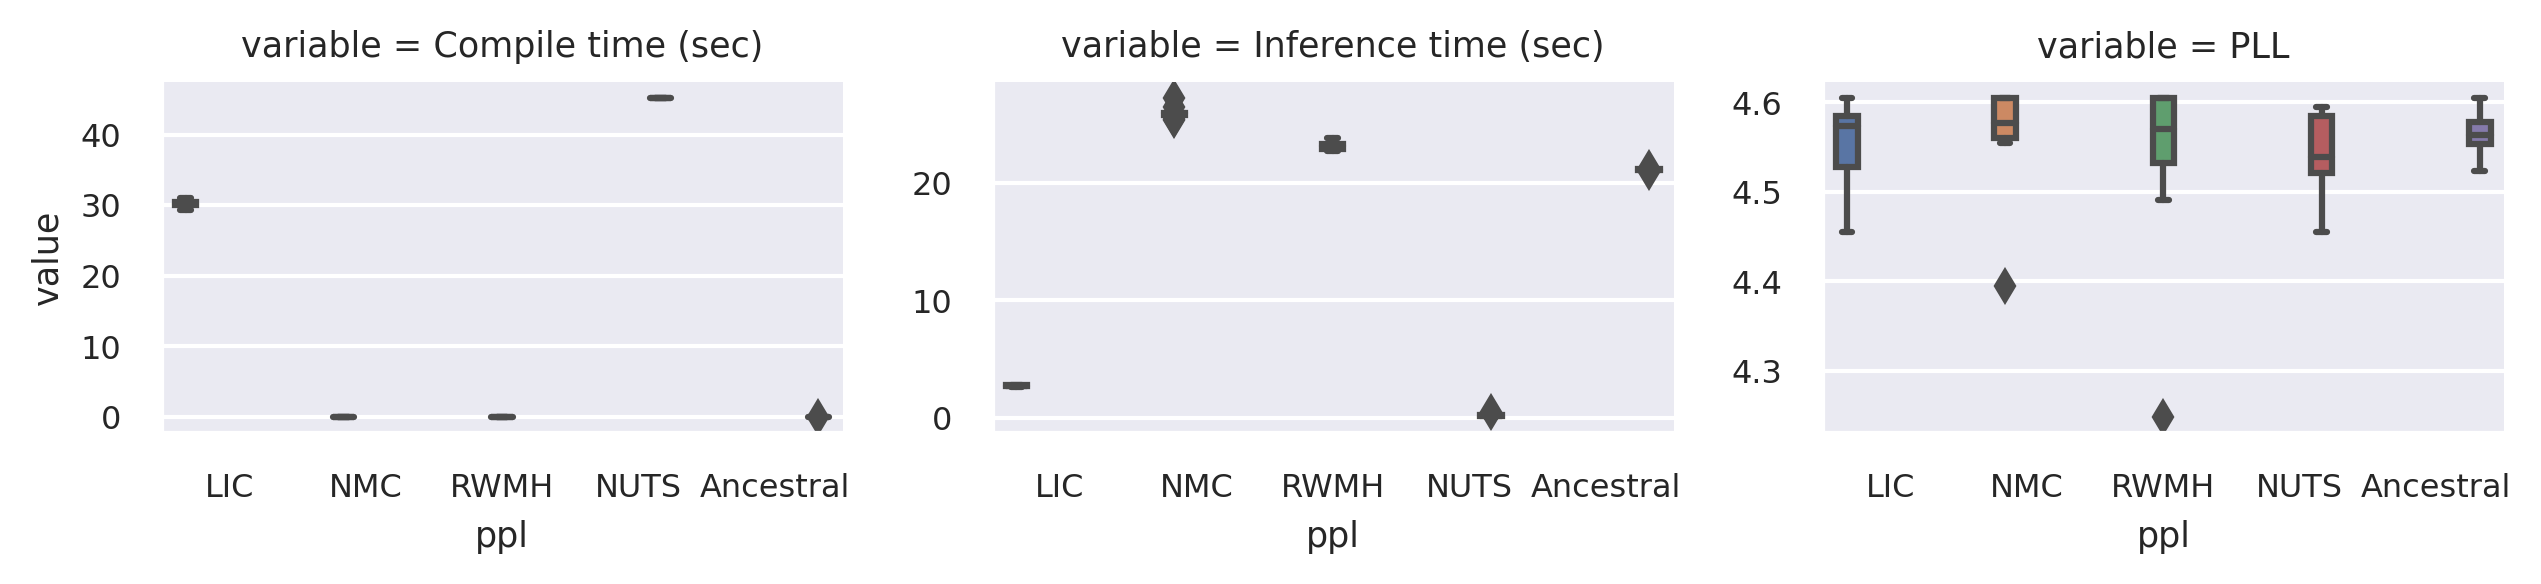

In [37]:
import seaborn as sns
import pickle
sns.set(font_scale=0.7)

#pickle.dump(melted, open("outputs/blr_pll.pkl", "wb"))
#melted = pickle.load(open("outputs/blr_pll.pkl", "rb"))
g = sns.catplot(data=melted, col="variable", x="ppl", y="value", hue="ppl", sharey=False, kind="box", col_wrap=3)  

g.fig.set_size_inches(8.5, 2)
g.fig.set_dpi(300)
g.fig.tight_layout()
g.fig.savefig('blr_pll.pdf', dpi=300)

In [38]:
import arviz as az
dataset_dict = {}

for ppl in list(posterior_samples.keys()):
    trials = posterior_samples[ppl]
    
    data = {}
    for i, chains in enumerate(trials):
        for j, sample in enumerate(chains):
            for var in sample:
                if var not in data:
                    if sample[var].ndim == 0:
                        data[var] = np.zeros((len(trials), len(chains)))
                    else:
                        data[var] = np.zeros((len(trials), len(chains), sample[var].shape[0]))
                data[var][i][j] = sample[var]
    dataset_dict[ppl] = az.convert_to_inference_data(data)
    dataset_dict[ppl].log_likelihood = az.dict_to_dataset({
        ppl:posterior_predictive[ppl]
    })

In [39]:
len(trials[0])

100

In [40]:
trials[0][0]['alpha'].size

1

In [41]:
trials = pickle.load(open(f"{most_recent}/posterior_samples.pkl", "rb"))['stan']
data = {}
for i, chains in enumerate(trials):
        for j, sample in enumerate(chains):
            for var in sample:
                if var not in data:
                    if sample[var].size == 1:
                        data[var] = np.zeros((len(trials), len(chains)))
                    else:
                        data[var] = np.zeros((len(trials), len(chains), sample[var].shape[1]))
                data[var][i][j] = sample[var]
ppl = 'NUTS'
dataset_dict[ppl] = az.convert_to_inference_data(data)
# dataset_dict[ppl].log_likelihood = az.dict_to_dataset({
#     ppl:posterior_predictive[ppl]
# })

In [44]:
melted = pd.concat([
    pd.concat([pd.DataFrame({
        'ESS': filter(lambda x: x < 1e4, np.hstack([az.ess(dataset_dict[ppl])['alpha'].values, az.ess(dataset_dict[ppl])['beta'].values])),
        'ppl': ppl
    }) for ppl in sorted(set(df.ppl))]).melt(id_vars=['ppl'], value_vars=['ESS']),
    pd.concat([pd.DataFrame({
        'Rhat': filter(lambda x: x < 1e4, np.hstack([az.rhat(dataset_dict[ppl])['alpha'].values, az.rhat(dataset_dict[ppl])['beta'].values])),
        'ppl': ppl
    }) for ppl in sorted(set(df.ppl))]).melt(id_vars=['ppl'], value_vars=['Rhat'])
])
melted['ppl'] = melted['ppl'].replace(ppl_replace)

In [47]:
melted_new = melted[melted.ppl == 'Ancestral']

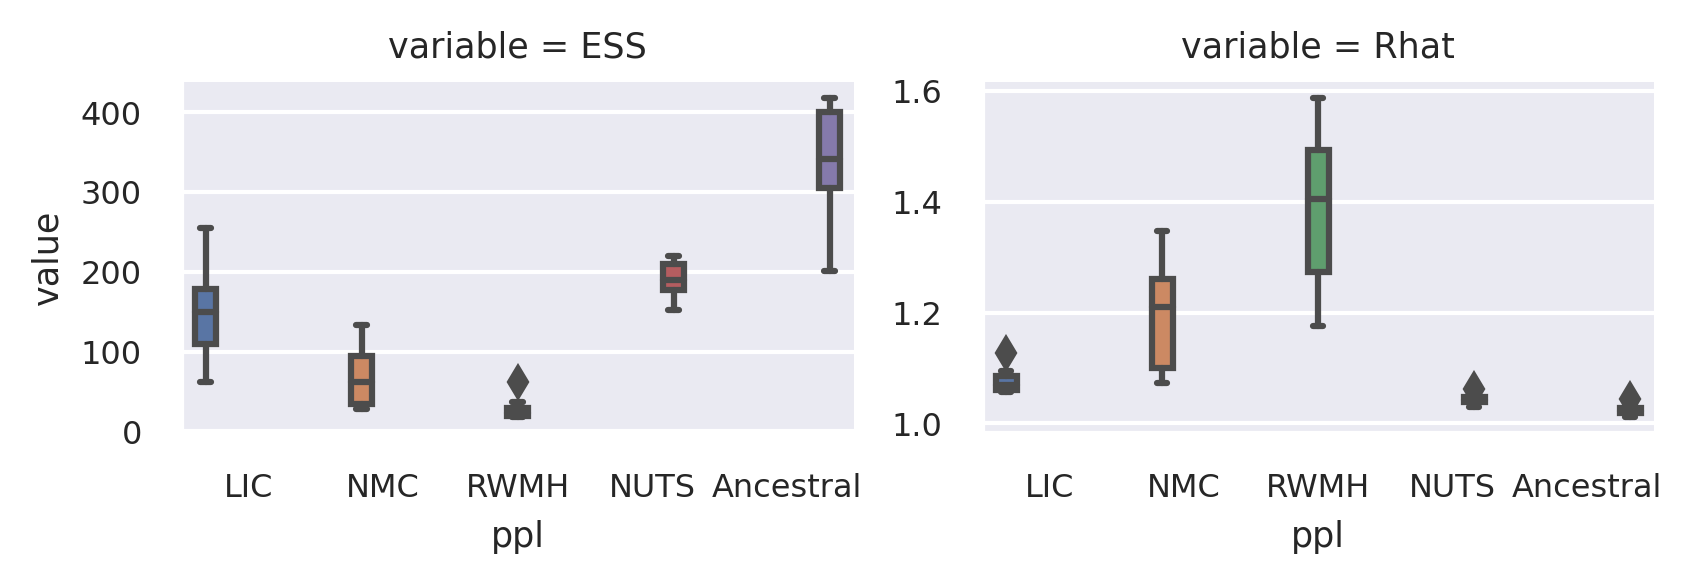

In [48]:
import pickle
import seaborn as sns
#pickle.dump(melted, open("outputs/blr_ess.pkl", "wb"))
melted = pickle.load(open("outputs/blr_ess.pkl", "rb"))
melted = melted.append(melted_new)
g = sns.catplot(data=melted, col="variable", x="ppl", y="value", hue="ppl", sharey=False, kind="box")    

g.fig.set_size_inches(8.5*2/3, 2)
g.fig.set_dpi(300)
g.fig.tight_layout()
g.fig.savefig('blr_ess_rhat.pdf', dpi=300)